In [1]:
import os.path

import torch
import matplotlib.pyplot as plt

from utils import WrapLogger, Params, ROOT_DIR
from plants.duffing import ReverseDuffingOscillator
from plants.van_der_pol import VanDerPol
from models.noderen import ContractiveNodeREN
from models.non_linearities import MappingT


In [2]:
# ----- System ----------
sys_dyn = ReverseDuffingOscillator(h=0.001)
# sys_dyn = VanDerPol(h=0.003)

In [3]:
# ----- Parameters ----------
p = Params()

# Dimensions of T and \tau
p.n_tau = 160
# Observer dimensions
p.nx = 4
p.nq = 8
p.x_init_random = True

# Noise for simulations
p.w_std = 10. #*0
p.v_std = 10. #*0 + 100.
p.t_end = 10000

p.plot_batch_size = 100

# ----- Seed ----------
p.seed = 0
torch.manual_seed(p.seed)

In [4]:
# ----- System ----------
sys_dyn = ReverseDuffingOscillator(h=0.001)
# sys_dyn = VanDerPol(h=0.003)

In [5]:
# ----- Generate Noise ----------
w = torch.zeros(p.plot_batch_size, p.t_end, sys_dyn.state_dim)
v = torch.zeros(p.plot_batch_size, p.t_end, sys_dyn.out_dim)
w_noisy = p.w_std * sys_dyn.h * torch.randn(p.plot_batch_size, p.t_end, sys_dyn.state_dim)
v_noisy = p.v_std * sys_dyn.h * torch.randn(p.plot_batch_size, p.t_end, sys_dyn.out_dim)

In [6]:
# ----- Define Observer -----
p.ny = p.nx
p.nu = sys_dyn.out_dim
sys_z = ContractiveNodeREN(p.nx, p.ny, p.nu, p.nq, h=sys_dyn.h, bias=True)

coup = MappingT(dim_inputs=p.ny, dim_hidden=p.n_tau, dim_small=sys_dyn.state_dim)

In [7]:
# ----- Load parameters -----
folder_name = os.path.join(ROOT_DIR, "experiments", "trained_models", sys_dyn.name)
file_name = sys_dyn.name + "_nx%i_nq%i_ntau%i" % (p.nx, p.nq, p.n_tau) + ".pth"
model_path = os.path.join(folder_name, file_name)
if os.path.exists(model_path):
    print("Loading model from: %s" % model_path)
    checkpoint = torch.load(model_path)
    sys_z.load_state_dict(checkpoint['sys_z'])
    coup.load_state_dict(checkpoint['coup'])
    sys_z.updateParameters()
else:
    print("Model is not yet trained. Please run the training first. Use the experiments/run_observer.py file.")

Loading model from: /home/cgalimberti/repos/learning_c_obs/experiments/trained_models/ReverseDuffingOscillator/ReverseDuffingOscillator_nx4_nq8_ntau160.pth


# PLOTS !

In [8]:
# PLOTS
# Define variables
time = torch.linspace(0, (p.t_end-1)*sys_dyn.h, p.t_end)
x_init = torch.rand(p.plot_batch_size, 1, sys_dyn.state_dim) * (sys_dyn.axis_limit['x0high'] - sys_dyn.axis_limit['x0low']) + sys_dyn.axis_limit['x0low']
x, y = sys_dyn.rollout(x_init, w, v, p.t_end)
x_noisy, y_noisy = sys_dyn.rollout(x_init, w_noisy, v_noisy, p.t_end)

# Calculate rollouts
if p.x_init_random:
    x_hat_init = torch.rand(p.plot_batch_size, 1, sys_dyn.state_dim) * (sys_dyn.axis_limit['x0high'] - sys_dyn.axis_limit['x0low']) + sys_dyn.axis_limit['x0low']
else:
    x_hat_init = x_init
xi_init = coup.forward(coup.lift(x_hat_init))
xi = sys_z.rollout(xi_init, y, p.t_end)
x_hat = coup.delift(coup.forward_inverse(xi))
xi_noisy = sys_z.rollout(xi_init, y_noisy, p.t_end)
x_hat_noisy = coup.delift(coup.forward_inverse(xi_noisy))

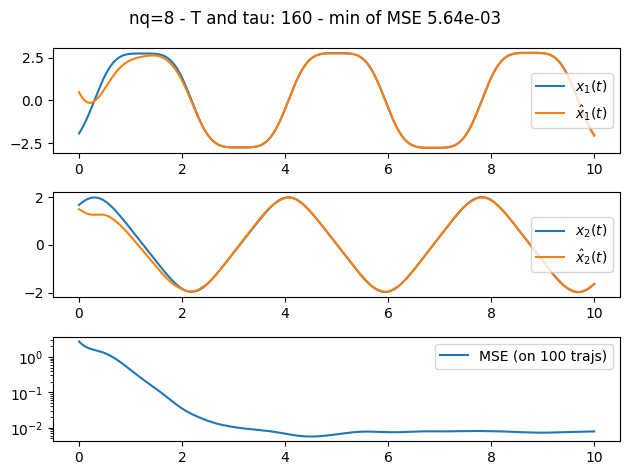

In [14]:
# NOISELESS
# x-dynamics
plt.figure()
for i in range(sys_dyn.state_dim):
    plt.subplot(sys_dyn.state_dim + 1, 1, i + 1)
    plt.plot(time, x[0, :, i], label='$x_%i(t)$' % (i + 1))
    plt.plot(time, x_hat[0,:,i].detach(), label=r'$\hat{x}_%i(t)$' % (i + 1))
    plt.legend(loc="right")
plt.subplot(sys_dyn.state_dim + 1, 1, sys_dyn.state_dim + 1)
mse = ((x - x_hat).detach()**2).mean(axis=0).mean(axis=-1)
plt.plot(time, mse, label='MSE (on %i trajs)' % x.shape[0])
plt.legend(loc="upper right")
plt.yscale("log")
plt.suptitle("nq=%i - T and tau: %i - min of MSE %.2e" % (p.nq, p.n_tau, min(mse)))
plt.tight_layout()
plt.show()

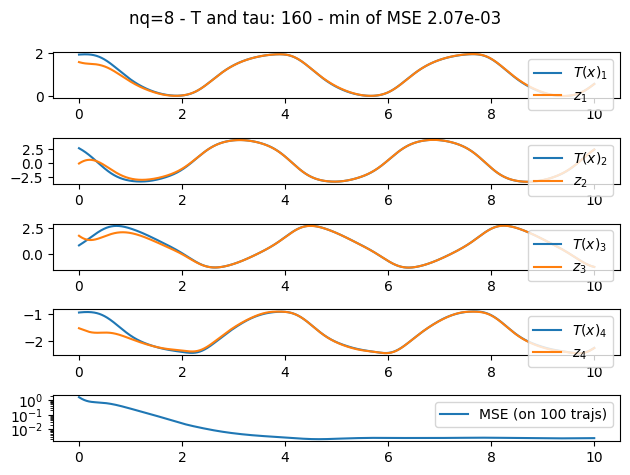

In [18]:
# NOISELESS
# z-dynamics
plt.figure()
Tx = coup.forward(coup.lift(x)).detach()
for i in range(p.nx):
    plt.subplot(sys_z.nx + 1, 1, i + 1)
    plt.plot(time, Tx[0, :, i], label='$T(x)_%i$' % (i + 1))
    plt.plot(time, xi[0,:,i], label='$z_%i$' % (i + 1))
    plt.legend(loc="upper right")
# -- plot error
plt.subplot(sys_z.nx + 1, 1, sys_z.nx + 1)
mse = ((xi - Tx)**2).mean(axis=0).mean(axis=-1)
plt.semilogy(time, mse, label='MSE (on %i trajs)' % xi.shape[0])
plt.legend(loc="upper right")
plt.suptitle("nq=%i - T and tau: %i - min of MSE %.2e" % (p.nq, p.n_tau, min(mse)))
plt.tight_layout()
plt.show()

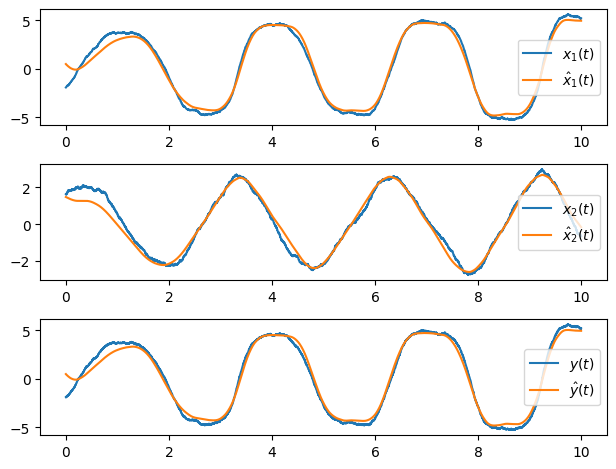

In [17]:
# NOISE:
# x-dynamics
plt.figure()
for i in range(sys_dyn.state_dim):
    plt.subplot(sys_dyn.state_dim + 1, 1, i + 1)
    plt.plot(time, x_noisy[0, :, i], label='$x_%i(t)$' % (i + 1))
    plt.plot(time, x_hat_noisy[0,:,i].detach(), label=r'$\hat{x}_%i(t)$' % (i + 1))
    plt.legend(loc="right")
plt.subplot(sys_dyn.state_dim + 1, 1, sys_dyn.state_dim + 1)
plt.plot(time, y_noisy[0, :, 0], label=r"$y(t)$")
plt.plot(time, sys_dyn.output(x_hat_noisy[0,:,:]).detach(), label=r"$\hat{y}(t)$")
plt.legend(loc="right")
plt.tight_layout()
plt.show()

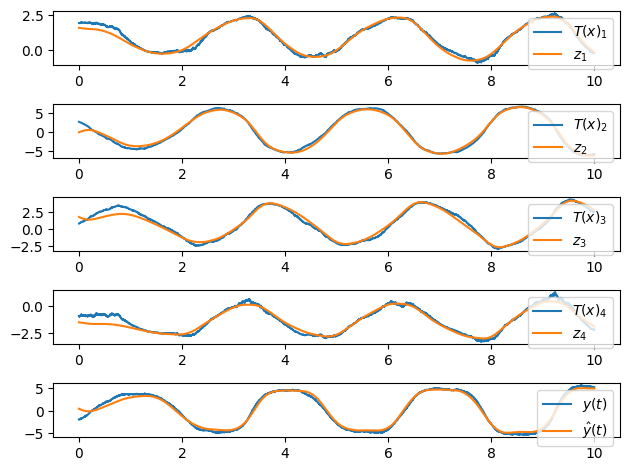

In [16]:
# NOISE
# z-dynamics
plt.figure()
Tx_noisy = coup.forward(coup.lift(x_noisy)).detach()
for i in range(p.nx):
    plt.subplot(sys_z.nx + 1, 1, i + 1)
    plt.plot(time, Tx_noisy[0, :, i], label='$T(x)_%i$' % (i + 1))
    plt.plot(time, xi_noisy[0,:,i], label='$z_%i$' % (i + 1))
    plt.legend(loc="upper right")
plt.subplot(sys_z.nx + 1, 1, sys_z.nx + 1)
plt.plot(time, y_noisy[0, :, 0], label=r"$y(t)$")
plt.plot(time, sys_dyn.output(x_hat_noisy[0,:,:]).detach(), label=r"$\hat{y}(t)$")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()